# 1. Set up

## 1. Packages and requirements

In [1]:
# Major builtin libraries
import os
import gc
import cv2
# import mat
import time
import random
import typing as t
from copy import deepcopy
from collections import defaultdict

In [2]:
# To work with Google Collab
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

In [3]:
import warnings  # If you want to disable warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# Classic packages for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Basic PyTorch
import torch
import torch.nn as nn
import torch.optim as optim  # Optimization algorithms
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
from torch.optim import lr_scheduler  # Dynamic learning rate adjusting
from torch.utils.data import DataLoader, Dataset  # For custom data presentation
# from torch.cuda import amp

In [6]:
# Utils
import joblib  # Pipelining and pickling (dump/load)
from tqdm import tqdm  # Progress bar for training process
from tempfile import TemporaryDirectory

# Classic ML tools
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold  # Cross-Validation

In [7]:
# !pip install torchmetrics colorama

In [8]:
# ML Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from torchmetrics.classification import F1Score  # F1 metric for multiclass

In [9]:
# Torch Computer Vision tools for images processing
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image, to_grayscale, to_tensor
from torchvision import models  # Pretrained models

In [10]:
# Albumentations is an OS library for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
# import torchvision.transforms as T  # We can use torch augmentations instead

In [11]:
# Output text colorizing
from colorama import Back, Style

def print_highlighted(text: str, bgcolor=Back.YELLOW) -> None:
    """
    Function to print a text with colored background.
    """
    print(bgcolor + text + Style.RESET_ALL)

In [12]:
# import wandb # MLOps platform to simplify and speed up the process of building ML models

In [13]:
# wandb.login() # We log in via pop-up,
# wandb.login(key=api_key)  # but you can also log in manually with function args

## 2. Configuration

In [14]:
CONFIG = {
    "seed": 2306,
    "epochs": 20,
    "image_dimension": 256,  # Depends on pretrained model used
    "model_name": "efficientnet_b0",  # Pretrained model we will use
    # "embedding_size": 512,  # Embedding output size
    "train_batch_size": 32,
    "val_batch_size": 64,
    "learning_rate": 1e-3,
    "min_lr": 1e-8,
    "min_loss_delta": 1e-7, # To stop training on plateau
    "weight_decay": 1e-7,
}

In [15]:
class Config:
    """
    Class to simplify access to Config: not dict but object with attributes
    """
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

In [16]:
config = Config(config_dict=CONFIG)
del CONFIG

In [17]:
# Work example
config.seed

2306

## 3. Set Seed for Reproducibility

In [18]:
def set_seed(seed=42):
    """
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True  # When False, this option makes CUDA reproducible, BUT the performance might suffer

    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed=config.seed)

# 2. Data

# 1. Location

In [146]:
config.repo = '760-data-cars/all_cars_yolodata/'  # dataset name on Kaggle
# config.repo = 'data/'  # dataset name on local device
# config.repo = 'car_brand_detection/'  # Google Collab

config.root = '/kaggle/input/' + config.repo
# config.root = 'drive/MyDrive/' + config.repo
# config.root = '../'


config.data = config.root

config.train_images_path  = '/kaggle/input/760-data-cars/all_cars_yolodata/train'
config.test_images_path = '/kaggle/input/760-data-cars/all_cars_yolodata/test'

config.train_labels  = '/kaggle/input/760-data-cars/train_labels.csv'
config.test_labels = '/kaggle/input/760-data-cars/test_labels.csv'

config.model_path = '/kaggle/input/model-efficient/fine-tuned_efficientnet_b0.pth'


In [20]:
def get_file_path_by_id(file_id, dir=config.root):
    return os.path.join(dir, str(file_id) + ".jpg")

## 2. Custom Data representation

In [21]:
def apply_label_encoding(data: t.Union[pd.DataFrame, np.array],
                         encoder_name: os.path,
                         column='label', action='encode',
                         ):
    """
    One Hot encoding. We apply encoding by replacing the label column in dataframe.
    As for decoding data back, we work with vector-array (as it's most likely to
    be a prediction result)
    """
    encoder = LabelEncoder()
    if action == 'encode':
        # We transform dataframe here. Nothing returns
        data[column] = encoder.fit_transform(data[column])
        with open(f"{encoder_name}_LEncoder.pkl", "wb") as fp:
            joblib.dump(encoder, fp)
    elif action == 'decode':
        # We pass vector here. Result is a vector
        with open(f"{encoder_name}_LEncoder.pkl", "rb") as fp:
            encoder: LabelEncoder = joblib.load(fp)
        return encoder.inverse_transform(data)

In [22]:
class CustomImagesDataset(Dataset):
    """
    """
    def __init__(self, data: pd.DataFrame=None, images_path: os.path=None, labels_path:os.path=None, transform_images: A.Compose=None, encoder_name: str=None):
        """

        """
        super().__init__()
        assert (data is not None) or (labels_path is not None and images_path is not None)

        if data is None:
            data = pd.read_csv(labels_path)
            data['file_path'] = data['id'].apply(get_file_path_by_id, dir=images_path)

        self.images_paths = data['file_path'].values
        self.encoder_name = encoder_name if encoder_name else self.__hash__()  # We use hash as a unique name
        print_highlighted(f"Label Encoder saved with id `{self.encoder_name}`")
        apply_label_encoding(data=data, action='encode', encoder_name=self.encoder_name)
        self.labels = data['label'].values
#         self.indexes = data['id'].values
        self.transform_images = transform_images
        self.__set_dataset_len()

    def __set_dataset_len(self):
        self.length = self.labels.shape[0] # Number of rows

    def __len__(self):
        """
        We calculate the len in another function, so that we are able to slice.
        """
        return self.length

    def decode_labels(self, labels_vector):
        return apply_label_encoding(data=labels_vector, action='decode', encoder_name=self.encoder_name)

    def __getitem__(self, index) -> tuple[torch.Tensor, int]:
        """ Function to return item by indexing the dataset """

        if not isinstance(index, int) and isinstance(index, slice):
            # It's not an index, but slice.
            # We will return the part of data by making a copy of the dataset
            index: slice
            self = deepcopy(self)
            self.length = index.stop  # Cut the length of dataset.
            self.labels = self.labels[:self.length]
            return self
        assert self.__len__() >= index

        image = to_pil_image(read_image(self.images_paths[index]))
        if self.transform_images:
            # Albumentations requires us to convert image to Numpy Array
            image = self.transform_images(image=np.array(image))['image']

        label = self.labels[index]
        return image, label


    @property
    def classes_(self):
        return self.decode_labels(np.unique(self.labels))


## 3. Augmentations

We use Albumantations lib

In [23]:
data_transforms = {
    "train": A.Compose([
#         A.ToRGB(),
        A.Resize(config.image_dimension, config.image_dimension),
        A.ShiftScaleRotate(shift_limit=0.1,
                           scale_limit=0.15,
                           rotate_limit=30,
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=30,
                sat_shift_limit=30,
                val_shift_limit=30,
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.01,0.01),
                contrast_limit=(-0.01, 0.01),
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2() # Advanced analogue of T.ToTensor
    ], p=1.),

    "val": A.Compose([
#         A.ToRGB(),
        A.Resize(config.image_dimension, config.image_dimension),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

## 4. Load the data and have a look

In [24]:
train_dataset = CustomImagesDataset(labels_path=config.train_labels, images_path=config.train_images_path, transform_images=data_transforms['train'], encoder_name='train')

Label Encoder saved with id `train`


In [25]:
test_dataset = CustomImagesDataset(
    labels_path=config.test_labels,
    images_path=config.test_images_path,
    transform_images=data_transforms['val'],
    encoder_name='test',
)

Label Encoder saved with id `test`


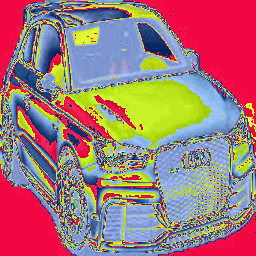

In [26]:
to_pil_image(train_dataset[60][0])

In [27]:
config.num_of_classes = len(train_dataset.classes_)
config.num_of_classes

760

Below we ensure that the test dataset doesn't contain unknown data

In [28]:
assert not bool(set(test_dataset.classes_) - set(train_dataset.classes_))

In [29]:
print(*train_dataset.classes_[:20], sep=';  ', end='...')

Acura_MDX;  Alfa Romeo_Giulietta;  Audi_100;  Audi_80;  Audi_A1;  Audi_A3;  Audi_A4;  Audi_A5;  Audi_A6;  Audi_A7;  Audi_A8;  Audi_Q3;  Audi_Q5;  Audi_Q7;  Audi_R8;  Audi_RS6;  Audi_S5;  Audi_S8;  Audi_TT;  BAW_FENIX...

# 3. Model

## 1. Getting the pretrained model

In [143]:
def get_model(model_name='resnet18', from_path=None, pretrained=False, freeze_layers=0.0, get_embeddings=False) -> torch.nn.Module:
    got_model = False
    if from_path:
        try:
            model = torch.load(from_path)
            got_model = True
        except FileNotFoundError:
            pass
    if not got_model:
        model = getattr(models, model_name) # We use builtin function
        model = model(
        weights=('DEFAULT' if pretrained else None)
        )
        return model

    if bool(freeze_layers):
        params = list(model.parameters())
        for param in params[:int(len(params)*freeze_layers)]:
            # Freeze some layers
            param.requires_grad = False

    if get_embeddings:
        # That means remove classifyer (last layer):
        model = nn.Sequential(*list(model.children())[:-1])
    return model

We can fine-tune the model or train from scratch

In [31]:
# model = get_model(
#     model_name=config.model_name,
#     pretrained=True,
#     freeze_layers=0.0,
#     get_embeddings=False
# )

Or fine-tine the model that we've trained before

In [147]:
model = get_model(
    from_path=config.model_path,
    pretrained=True,
    freeze_layers=0.0,
    get_embeddings=False
)

In [148]:
model 

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## 2. Set up the output layer

Efficient Model consists of 3 blocks (2 Sequential and one Avg Pooling between them. Let's have a look at last two layers

Last layer is classifier.

In [43]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=760, bias=True)
  (2): Softmax(dim=-1)
)

Let's change the number of classes (according with our task), and add a Softmax

In [44]:
fc_dropout = 0.3

In [45]:
model.classifier = nn.Sequential(
    nn.Dropout(p=fc_dropout, inplace=True),
    nn.Linear(in_features=model.classifier[1].in_features, out_features=config.num_of_classes, bias=True),
    nn.Softmax(dim=-1)
 )

For model loaded from path we can also change the dropout ratio (without affecting the weights)

In [46]:
model.classifier[0] = nn.Dropout(p=fc_dropout, inplace=False)

In [47]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

# 4. Various

## 1. Quality metrics

We will use accuracy and F1 score for out classification task

In [48]:
f1_score = F1Score(task="multiclass", num_classes=config.num_of_classes, average="macro")

## 2. Device

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
f1_score = f1_score.to(device)
torch.cuda.empty_cache()

## 3. Data processing format

In [50]:
config.train_batch_size, config.val_batch_size = 128, 128

In [51]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=config.train_batch_size,
                              shuffle=True,
                              num_workers=os.cpu_count(),
)

In [52]:
test_dataloader = DataLoader(test_dataset,
                              batch_size=config.val_batch_size,
                              shuffle=False,
                              num_workers=os.cpu_count(),
)

# 5. Initialize the train process

## 1. Functions to plot the result

In [83]:
def plot_two_curves(
        title: str,
        train_curve: list[float],
        val_curve: list[float],

):
    plt.figure(figsize=(16, 8))
    plt.title(title)
    plt.plot(train_curve, label=f'Train {title}')
    plt.plot(val_curve, label=f'Valid {title}')
    plt.legend()
    plt.grid()
    plt.show()
    #plt.savefig(title)

In [54]:
def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float]=None,
        valid_accuracy: list[float]=None,
        train_f1_score: list[float]=None,
        valid_f1_score: list[float]=None,
        title: str = None
):
    plot_two_curves(
        'Loss',
        train_loss,
        valid_loss
    )

    if train_accuracy and valid_accuracy:
        plot_two_curves(
            'accuracy',
            train_accuracy,
            valid_accuracy
        )

    if train_f1_score and valid_f1_score:
        plot_two_curves(
            'F1 score',
            train_f1_score,
            valid_f1_score
        )


## 2. Training and evaluation functions

In [55]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch: str):
    model.train()

    train_loss = 0.0
    train_correct = 0.0
    train_f1 = 0.0
    n_batches = 0
    data_size = 0
    
    with tqdm(dataloader, desc=f'Epoch: {epoch}', unit="batch") as tepoch:
        for images, labels in tepoch:
            n_batches += 1
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            embeddings = model(images)

            loss = criterion(embeddings, labels)
            loss.backward()
            optimizer.step()

            loss = loss.item()  # item() extracts scalar
            train_loss += loss

            _, predicted = torch.max(embeddings.data, 1)

            train_correct += (predicted == labels).sum().item()
            data_size += labels.size(0)
            train_accuracy = train_correct / data_size

            f1 = f1_score(predicted, labels).item()
            train_f1 += f1
            tepoch.set_postfix(loss=loss, acc=train_accuracy)

    train_loss /= n_batches
    train_f1 /= n_batches
    gc.collect()
    torch.cuda.empty_cache()

    return train_loss, train_accuracy, train_f1

In [56]:
@torch.inference_mode()
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()

    val_loss = 0.0
    val_correct = 0.0
    val_f1_score = 0.0
    data_size = 0
    n_batches = 0

    with tqdm(dataloader, desc="Validation",unit="batch") as tepoch:
        for images, labels in tepoch:
            n_batches += 1
            images = images.to(device)
            labels = labels.to(device)
            embeddings = model(images)

            loss = criterion(embeddings, labels).item()
            val_loss += loss

            _, predicted = torch.max(embeddings.data, 1)

            correct = (predicted == labels).sum().item()
            val_correct += correct
            data_size += labels.size(0)
            val_accuracy = val_correct / data_size

            f1 = f1_score(predicted, labels).item()
            val_f1_score += f1
            tepoch.set_postfix(loss=loss, acc=val_accuracy)

    val_loss /= n_batches
    val_f1_score /= n_batches
    gc.collect()
    torch.cuda.empty_cache()

    return val_loss, val_accuracy, val_f1_score

## 3. Training cycle

In [57]:
  def train_model(model, train_loader, val_loader,
                criterion=None, optimizer=None, num_epochs=5,
                scheduler=None, device=torch.device("cpu"),
                save_model_to=None):
    since = time.time()

    train_loss_history, valid_loss_history = [], []
    train_acc_history, valid_acc_history = [], []
    train_f1_history, valid_f1_history = [], []


    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        for epoch in range(num_epochs):
            train_loss, train_accuracy, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch=f'{epoch+1}/{num_epochs}')
            val_loss, val_accuracy, val_f1 = validate_one_epoch(model, val_loader, criterion, device,)

            
            print_highlighted(
                f"Loss: {val_loss:.4f} - Accuracy: {val_accuracy:.4f} - F1: {val_f1:.4f} - LR: {get_lr(optimizer)}"
            )

            if not valid_loss_history or val_loss < valid_loss_history[-1]:
                # If it's either first step (history is empty) or our weights are getting better
                print_highlighted("New weights were applied.\n", bgcolor=Back.CYAN)
                torch.save(model.state_dict(), best_model_params_path)

            scheduler.step(val_loss)

            train_loss_history.append(train_loss)
            valid_loss_history.append(val_loss)
            train_acc_history.append(train_accuracy)
            valid_acc_history.append(val_accuracy)
            train_f1_history.append(train_f1)
            valid_f1_history.append(val_f1)

            del train_loss
            del val_loss
            gc.collect()
            torch.cuda.empty_cache()

        time_elapsed = time.time() - since
        print_highlighted(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

        if save_model_to:
            torch.save(model, save_model_to)
            print(f"Model was saved to: {save_model_to}")

        history = dict(
            train_loss=train_loss_history,
            valid_loss=valid_loss_history,
            train_accuracy=train_acc_history,
            valid_accuracy=valid_acc_history,
            train_f1_score=train_f1_history,
            valid_f1_score=valid_f1_history,
        )
    return model, history

# 6. Hyperparametres

Custom Loss Function

In [49]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.alpha is not None and self.alpha != 1.0:
            focal_loss = alpha * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [72]:
criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss(alpha=1.0, gamma=2, reduction = 'mean')

In [73]:
config.learning_rate = 5e-4
config.epochs = 40
config.weight_decay = 1e-5
config.min_loss_delta = 0.1

In [52]:
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.learning_rate, weight_decay = config.weight_decay)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
# optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.8)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [77]:
optimizer = torch.optim.Adam(
    [
    {'params': filter(lambda p: p.requires_grad, model.features.parameters())},
    {'params': model.classifier.parameters(), 'lr': 5e-4}
    ],
    lr=config.learning_rate, 
    weight_decay = config.weight_decay)


In [78]:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5, verbose=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', patience = 5, factor=0.5, 
    min_lr=config.min_lr , verbose=False,
    threshold = config.min_loss_delta)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5, verbose=False)
# scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.5, verbose=False)

In [79]:
def get_lr(optimizer):
    """
    For some schedulers we don't have `get_last_lr()` method.
    So, we will get last lr ourselves.
    """
    return list(
        [group['lr'] for group in optimizer.param_groups]
    )

In [80]:
get_lr(optimizer)

[0.0005, 0.0005]

# 7. Run the training process

In [81]:
model, history = train_model(model=model,
                    train_loader=train_dataloader,
                    val_loader=test_dataloader,
                    criterion=criterion,
                    optimizer=optimizer,
                    num_epochs=config.epochs,
                    device=device,
                    scheduler=scheduler,
                    save_model_to=f'fine-tuned_{config.model_name}.pth')

Validation: 100%|██████████| 22/22 [00:10<00:00,  2.08batch/s, acc=0.728, loss=5.99]


Loss: 5.9306 - Accuracy: 0.7279 - F1: 0.4886 - LR: [0.0005, 0.0005]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.19batch/s, acc=0.732, loss=5.97]


Loss: 5.9263 - Accuracy: 0.7315 - F1: 0.4999 - LR: [0.0005, 0.0005]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:11<00:00,  1.95batch/s, acc=0.733, loss=5.98]


Loss: 5.9227 - Accuracy: 0.7326 - F1: 0.4912 - LR: [0.0005, 0.0005]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:09<00:00,  2.23batch/s, acc=0.747, loss=5.94]


Loss: 5.9117 - Accuracy: 0.7467 - F1: 0.5193 - LR: [0.0005, 0.0005]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:09<00:00,  2.20batch/s, acc=0.735, loss=5.95]


Loss: 5.9224 - Accuracy: 0.7355 - F1: 0.5035 - LR: [0.0005, 0.0005]


Validation: 100%|██████████| 22/22 [00:10<00:00,  2.07batch/s, acc=0.744, loss=5.93]


Loss: 5.9101 - Accuracy: 0.7441 - F1: 0.5136 - LR: [0.0005, 0.0005]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:09<00:00,  2.21batch/s, acc=0.745, loss=5.94]


Loss: 5.9124 - Accuracy: 0.7445 - F1: 0.5186 - LR: [0.0005, 0.0005]


Validation: 100%|██████████| 22/22 [00:09<00:00,  2.20batch/s, acc=0.759, loss=5.91]


Loss: 5.8929 - Accuracy: 0.7586 - F1: 0.5315 - LR: [0.00025, 0.00025]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:09<00:00,  2.21batch/s, acc=0.76, loss=5.89] 


Loss: 5.8919 - Accuracy: 0.7596 - F1: 0.5373 - LR: [0.00025, 0.00025]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.19batch/s, acc=0.762, loss=5.91]


Loss: 5.8907 - Accuracy: 0.7618 - F1: 0.5401 - LR: [0.00025, 0.00025]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.01batch/s, acc=0.762, loss=5.9] 


Loss: 5.8882 - Accuracy: 0.7622 - F1: 0.5409 - LR: [0.00025, 0.00025]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.09batch/s, acc=0.774, loss=5.87]


Loss: 5.8779 - Accuracy: 0.7744 - F1: 0.5706 - LR: [0.00025, 0.00025]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.07batch/s, acc=0.775, loss=5.91]


Loss: 5.8791 - Accuracy: 0.7748 - F1: 0.5629 - LR: [0.00025, 0.00025]


Validation: 100%|██████████| 22/22 [00:10<00:00,  2.15batch/s, acc=0.778, loss=5.89]


Loss: 5.8740 - Accuracy: 0.7784 - F1: 0.5728 - LR: [0.000125, 0.000125]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.17batch/s, acc=0.78, loss=5.88] 


Loss: 5.8705 - Accuracy: 0.7798 - F1: 0.5753 - LR: [0.000125, 0.000125]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.20batch/s, acc=0.778, loss=5.89]


Loss: 5.8706 - Accuracy: 0.7784 - F1: 0.5735 - LR: [0.000125, 0.000125]


Validation: 100%|██████████| 22/22 [00:10<00:00,  2.04batch/s, acc=0.782, loss=5.87]


Loss: 5.8678 - Accuracy: 0.7816 - F1: 0.5778 - LR: [0.000125, 0.000125]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:09<00:00,  2.20batch/s, acc=0.791, loss=5.88]


Loss: 5.8634 - Accuracy: 0.7914 - F1: 0.5896 - LR: [0.000125, 0.000125]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.19batch/s, acc=0.791, loss=5.86]


Loss: 5.8610 - Accuracy: 0.7910 - F1: 0.5838 - LR: [0.000125, 0.000125]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.19batch/s, acc=0.791, loss=5.86]


Loss: 5.8603 - Accuracy: 0.7906 - F1: 0.5880 - LR: [6.25e-05, 6.25e-05]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.19batch/s, acc=0.794, loss=5.85]


Loss: 5.8598 - Accuracy: 0.7942 - F1: 0.5939 - LR: [6.25e-05, 6.25e-05]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.05batch/s, acc=0.795, loss=5.85]


Loss: 5.8585 - Accuracy: 0.7950 - F1: 0.5985 - LR: [6.25e-05, 6.25e-05]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.03batch/s, acc=0.798, loss=5.86]


Loss: 5.8573 - Accuracy: 0.7982 - F1: 0.6026 - LR: [6.25e-05, 6.25e-05]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.17batch/s, acc=0.798, loss=5.87]


Loss: 5.8565 - Accuracy: 0.7982 - F1: 0.5947 - LR: [6.25e-05, 6.25e-05]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:09<00:00,  2.23batch/s, acc=0.799, loss=5.88]


Loss: 5.8554 - Accuracy: 0.7986 - F1: 0.5946 - LR: [6.25e-05, 6.25e-05]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:09<00:00,  2.24batch/s, acc=0.8, loss=5.87]  


Loss: 5.8543 - Accuracy: 0.8000 - F1: 0.5981 - LR: [3.125e-05, 3.125e-05]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.05batch/s, acc=0.802, loss=5.87]


Loss: 5.8527 - Accuracy: 0.8018 - F1: 0.6006 - LR: [3.125e-05, 3.125e-05]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.09batch/s, acc=0.802, loss=5.88]


Loss: 5.8527 - Accuracy: 0.8022 - F1: 0.6042 - LR: [3.125e-05, 3.125e-05]


Validation: 100%|██████████| 22/22 [00:09<00:00,  2.21batch/s, acc=0.803, loss=5.87]


Loss: 5.8530 - Accuracy: 0.8032 - F1: 0.6072 - LR: [3.125e-05, 3.125e-05]


Validation: 100%|██████████| 22/22 [00:09<00:00,  2.21batch/s, acc=0.805, loss=5.88]


Loss: 5.8502 - Accuracy: 0.8054 - F1: 0.6110 - LR: [3.125e-05, 3.125e-05]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.19batch/s, acc=0.805, loss=5.88]


Loss: 5.8507 - Accuracy: 0.8047 - F1: 0.6099 - LR: [3.125e-05, 3.125e-05]


Validation: 100%|██████████| 22/22 [00:10<00:00,  2.03batch/s, acc=0.806, loss=5.87]


Loss: 5.8499 - Accuracy: 0.8065 - F1: 0.6121 - LR: [1.5625e-05, 1.5625e-05]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.07batch/s, acc=0.808, loss=5.88]


Loss: 5.8490 - Accuracy: 0.8076 - F1: 0.6124 - LR: [1.5625e-05, 1.5625e-05]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.20batch/s, acc=0.806, loss=5.88]


Loss: 5.8493 - Accuracy: 0.8058 - F1: 0.6137 - LR: [1.5625e-05, 1.5625e-05]


Validation: 100%|██████████| 22/22 [00:10<00:00,  2.03batch/s, acc=0.807, loss=5.87]


Loss: 5.8487 - Accuracy: 0.8068 - F1: 0.6129 - LR: [1.5625e-05, 1.5625e-05]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:10<00:00,  2.08batch/s, acc=0.805, loss=5.87]


Loss: 5.8493 - Accuracy: 0.8054 - F1: 0.6128 - LR: [1.5625e-05, 1.5625e-05]


Validation: 100%|██████████| 22/22 [00:10<00:00,  2.17batch/s, acc=0.805, loss=5.87]


Loss: 5.8491 - Accuracy: 0.8050 - F1: 0.6116 - LR: [1.5625e-05, 1.5625e-05]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:09<00:00,  2.24batch/s, acc=0.806, loss=5.87]


Loss: 5.8485 - Accuracy: 0.8058 - F1: 0.6107 - LR: [7.8125e-06, 7.8125e-06]
New weights were applied.



Validation: 100%|██████████| 22/22 [00:09<00:00,  2.23batch/s, acc=0.806, loss=5.87]


Loss: 5.8487 - Accuracy: 0.8058 - F1: 0.6138 - LR: [7.8125e-06, 7.8125e-06]


Validation: 100%|██████████| 22/22 [00:09<00:00,  2.22batch/s, acc=0.807, loss=5.86]


Loss: 5.8478 - Accuracy: 0.8068 - F1: 0.6113 - LR: [7.8125e-06, 7.8125e-06]
New weights were applied.

Training complete in 110m 38s
Model was saved to: fine-tuned_efficientnet_b0.pth


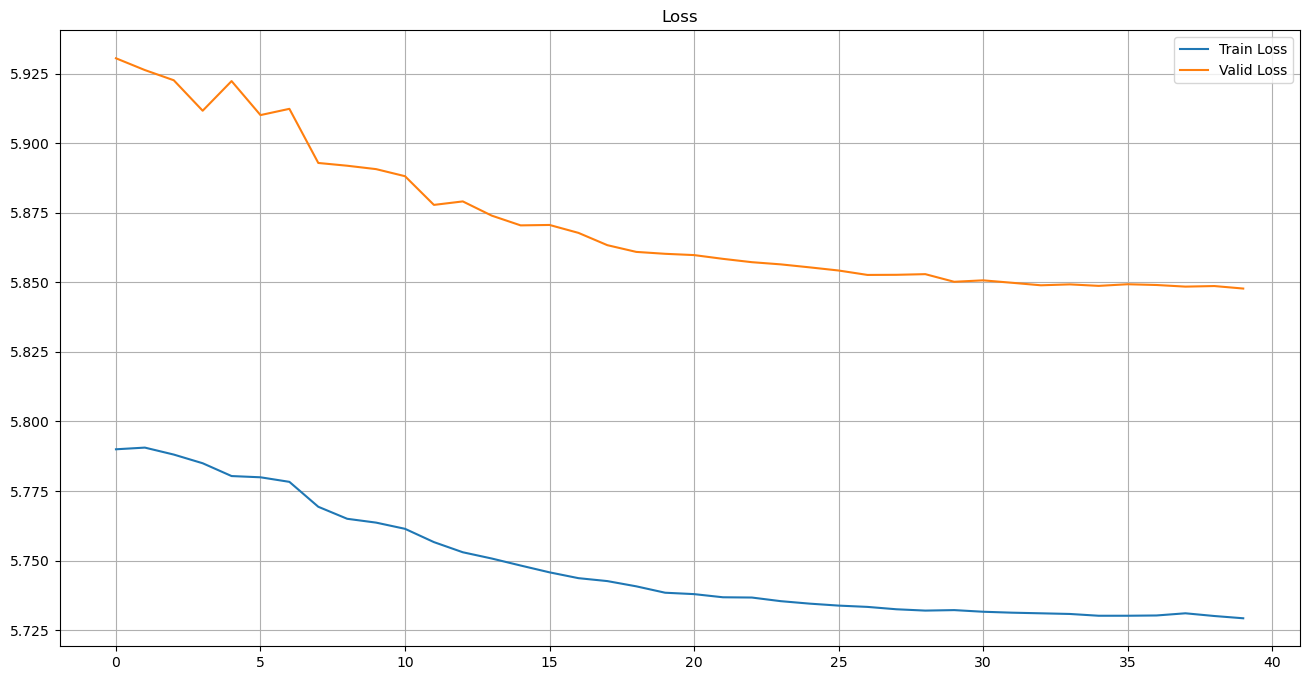

<Figure size 640x480 with 0 Axes>

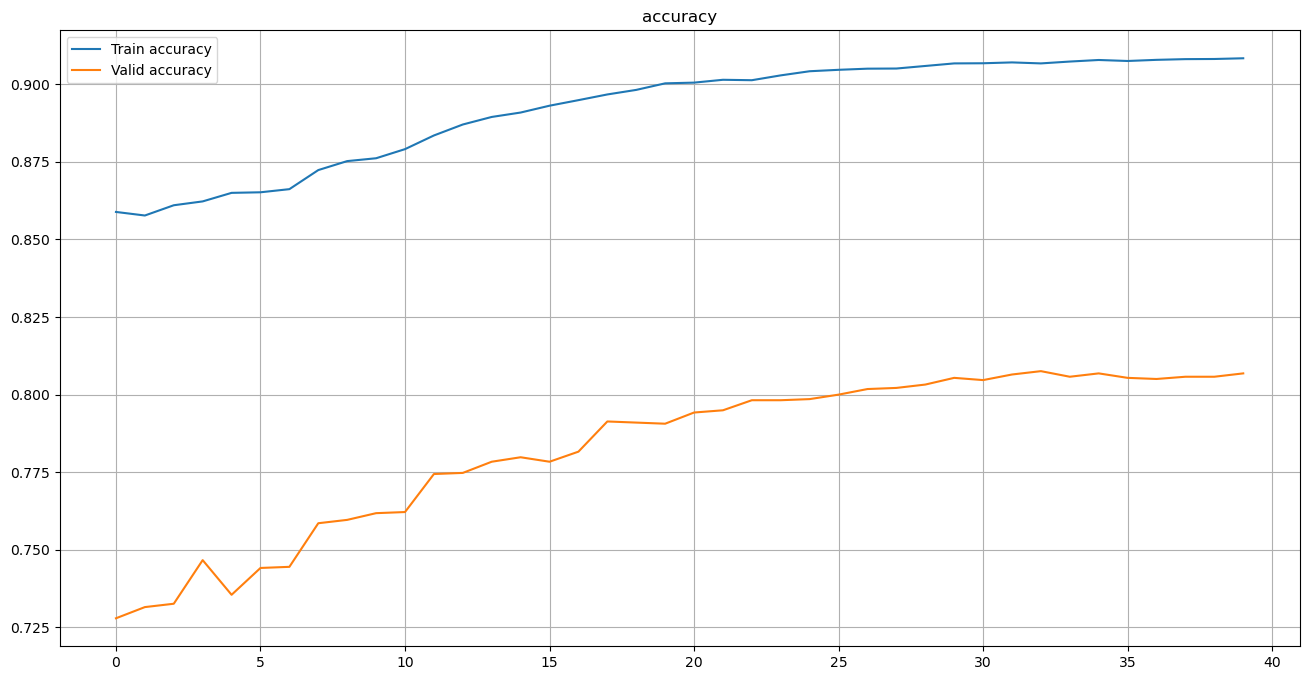

<Figure size 640x480 with 0 Axes>

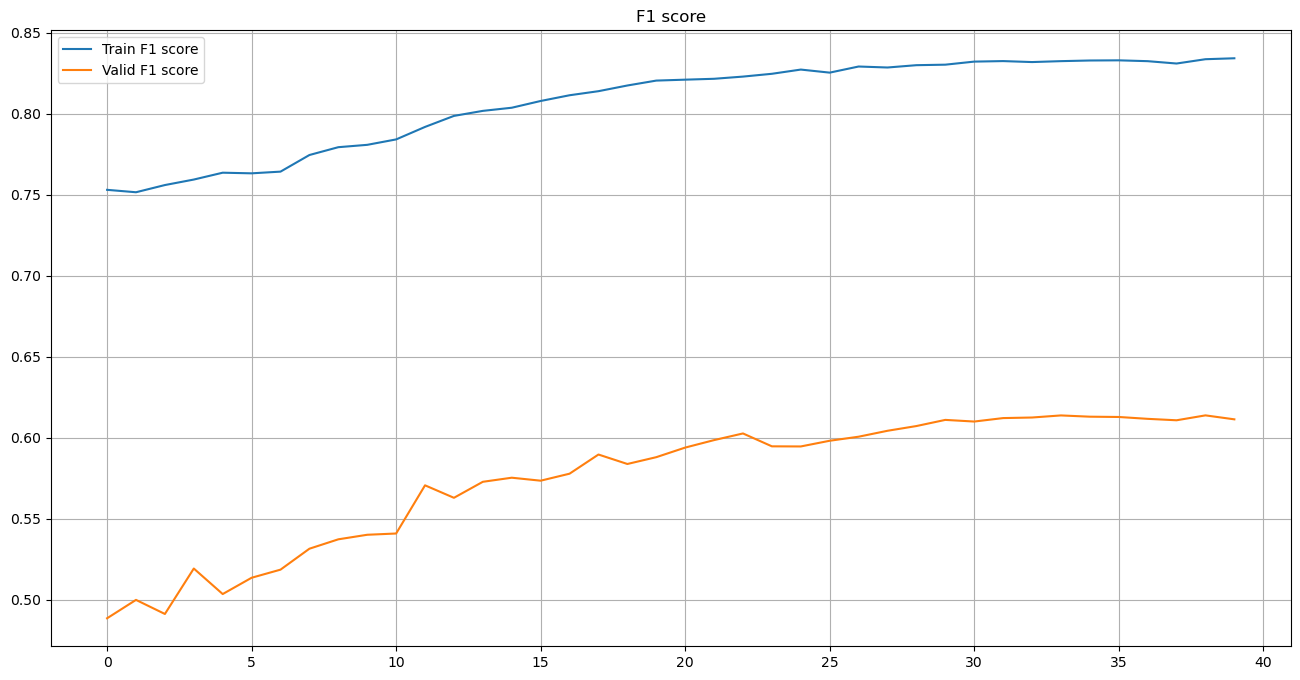

<Figure size 640x480 with 0 Axes>

In [84]:
plot_stats(
    **history,
    title=f"Model {config.model_name}"
)

# 8. Result evaluation

In [125]:
model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():
    for images, _ in test_dataloader:
        images = images.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

In [126]:
c_report = classification_report(test_dataset.labels, np.array(predictions), output_dict=True, zero_division=0)
c_report = pd.DataFrame(c_report).transpose()
c_report

,precision,recall,f1-score,support
0,1.000000,0.750000,0.857143,4.000000
1,1.000000,0.750000,0.857143,4.000000
2,0.750000,0.750000,0.750000,4.000000
3,0.750000,0.750000,0.750000,4.000000
4,1.000000,1.000000,1.000000,4.000000
...,...,...,...,...
758,0.500000,0.333333,0.400000,3.000000
759,0.666667,0.666667,0.666667,3.000000
accuracy,0.806847,0.806847,0.806847,0.806847
macro avg,0.761689,0.798409,0.762034,2775.000000


In [67]:
c_report[c_report['precision'] > 0][:-3].mean()

precision    0.811249
recall       0.891418
f1-score     0.829521
support      3.702830
dtype: float64

In [127]:
accuracy_score(test_dataset.labels, np.array(predictions))

0.8068468468468468

In [ ]:
from torchmetrics.classification import MulticlassF1Score
f1_score = MulticlassF1Score() # 0.76